In [2]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 48.9 MB/s 
     |████████████████████████████████| 3.3 MB 37.6 MB/s 
     |████████████████████████████████| 895 kB 35.6 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# GPT-2 for tweet generation

## Plain, without any finetuning
Just to see what will happen
Do not run the following cells if you want to finetune

In [60]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)

loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version

In [61]:
generator("The plandemic is for big pharma", max_length=30, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "The plandemic is for big pharma, not small farmers. For everyone who's sick and needs better health help, there's a huge problem"},
 {'generated_text': "The plandemic is for big pharma and in particular biotech. The American pharma has been working under President Obama's watch for the past six"},
 {'generated_text': 'The plandemic is for big pharma," said Haidt. "People are paying all the prices. But why should we pay for every'},
 {'generated_text': 'The plandemic is for big pharma lobbyists."\n\nThe industry\'s top lobbyist, William B. McCaul Jr., who previously served as'},
 {'generated_text': 'The plandemic is for big pharma, not low-cost health care. It\'s not a clean or healthy business model."\n\nHealth'}]

# Fine-tuning the model

## Load data

In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import pandas as pd
import nltk
nltk.download('punkt')
import numpy as np
import seaborn as sns
from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# load into a data frame
df = pd.read_csv("dev-1-task-1.csv") 
df.columns = ["id", "tweetid", "text"]
print(df)

      id  tweetid                                               text
0      2        1  There's a trail that MSS is checking that allo...
1      3        1  Why didn’t any of the “spiritual mediums” pred...
2      4        1  sfw?  defend the coincidence of Corona, Wuhan ...
3      5        1  Why isn’t Fonda &amp;her narcissistic , selfis...
4      6        1  They've done this for decades but #coronavirus...
..   ...      ...                                                ...
494  496        1  Indians are realising the contributions of our...
495  497        2  Yesterday a client called into my work (you kn...
496  498        1  Let us Pray  Heavenly Father we pray unto you ...
497  499        1  I don't say Sanjay Gandhi was right, but he wa...
498  500        1  The conspiracy theory presented by this work o...

[499 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


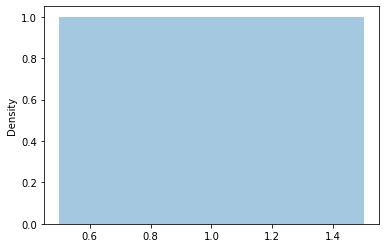

In [6]:
doc_lengths = []

for row in df:

    # get rough token count distribution
    tokens = nltk.word_tokenize(row)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [7]:
texts = df.text.tolist()
texts[0:10]

["There's a trail that MSS is checking that allowed the designer-bioweapon into China in the first place. In my opinion, CIA introduced SARS targeting China previously. Novel Coronavirus is round 2, another destabilizing mega-weapon in their godless inhuman arsenal! IMPO 🇨🇳🕵️\u200d♀️",
 'Why didn’t any of the “spiritual mediums” predict the #2020 #CoronavirusOutbreak? Not even with “I feel the letters C and V, they will become important”? Well, because there r no valid “mediums”. But if you know somebody who did and is (valid medium) please reply here. 🔮 #Corona',
 'sfw?\xa0 defend the coincidence of Corona, Wuhan Lab, Gates Foundation, Pirbright Inst., and timing of many deep state implosions in recent weeks.\xa0\xa0 Dial a distraction in full flex.\xa0 Transfer rate and death rate are not flu like.',
 'Why isn’t Fonda &amp;her narcissistic , selfish , wealthy buddies in Wuhan China protesting against the communist Chinese gov bioweapons &amp;the egregious negligence of spreading a de

In [30]:
len_texts = [len(text) for text in texts]

In [33]:
max(len_texts)

292

## GPT2 tokenizer

In [8]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


## Data Loaders

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

In [11]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    #{"input_ids": [...], "labels": [...], "attention_mask": [..]}.
    return {"input_ids":self.input_ids[idx], "labels": self.input_ids[idx], "attention_mask": self.attn_masks[idx] }

In [12]:
dataset = GPT2Dataset(texts, tokenizer, max_length=768)

In [14]:
# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  449 training samples
   50 validation samples


# Models

In [15]:
from transformers import AdamW, get_linear_schedule_with_warmup
import random

In [ ]:
# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
#model.cuda()

#Tell pytroch to run on cpu 
#device = torch.device("cpu")

In [16]:
# I'm not really doing anything with the config
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Set the seed value all over the place to make this reproducible.
seed_val = 17

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [17]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=2,  # batch size per device during training
    per_device_eval_batch_size=2,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    #logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

In [18]:
trainer.train()

***** Running training *****
  Num examples = 449
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 675


Step,Training Loss
10,8.949700
20,8.427600
30,7.961200
40,7.360200
50,6.298000
60,5.251400
70,3.416900
80,1.729900
90,1.055700
100,0.703000


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=675, training_loss=1.0749393812815349, metrics={'train_runtime': 687.4012, 'train_samples_per_second': 1.96, 'train_steps_per_second': 0.982, 'total_flos': 527940550656000.0, 'train_loss': 1.0749393812815349, 'epoch': 3.0})

In [19]:
#Save model
model_save_name = 'gpt2-finetune-twitter.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [25]:
#Reload model, can skip if doing all at once

# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))
model_save_name = 'gpt2-finetune-twitter.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

#This simply because there were no GPUs available at time of evaluating model, so I reverted to cpu
#device = torch.device("cpu")

loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version

<All keys matched successfully>

In [29]:
model.eval()

prompt = "<|startoftext|> Covid was planned"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=50
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 39751,   312,   373,  6027]])
0:  Covid was planned for a big festival in London. But Covid isn't really a festival. It's a country run hospital where people die due to their illness or other things. The same as Italy.


1:  Covid was planned to be more inclusive and less authoritarian. The focus of the Covid documentary was to prove its anti-nationalistic message. The media's focus on Covid's pandemic didn't help the film or its message.


2:  Covid was planned for the UK but a few months ago they lost the chance to win the vote. That's the future...


3:  Covid was planned as a quarantine from Covid in the U.S. This was not a bioweapon, only an attempt at keeping people who did not wear masks from taking the risk of infection. In fact this vaccine is completely harmless. So much for the conspiracy to come back from Africa (and its victims), America, Europe, Asia and all other parts of the world!!! The vaccine was created for the purpose of creating a cure against the 